# KET VR5 SAC Image Analysis
### Jonathan Ramos 8/21/2024

The usual, normalizing intensities and counting cell ns. I will also compute mean norm intensities per rat just in case. To keep things consistent with the rest of this paper, I will also apply the SNR thresholds we had previously determined as well as adjust for negative intensities by adding back in the absolute value of the minimum observed intensity for a given stain (effectively "raising the floor" of mean-background to 0).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Load in data

In [2]:
df = pd.read_csv('KET_VR5_SAC_FINAL.csv').drop('Unnamed: 0', axis=1)
df = df.drop_duplicates()

# adding a combined treatment combination col for convenience later
df['treatment'] = df.apply(lambda x: '_'.join([x.react, x.treat]), axis=1)

print(df.columns)
print(df.shape)
df.head()

Index(['iid_rid', 'dummy_PV', 'dummy_WFA', 'dummy_cFos', 'image_name',
       'roi_id', 'stain', 'CoM_x', 'CoM_y', 'background', 'mean_intensity',
       'mean-background', 'filename', 'rat_n', 'grouping', 'agg_grouping',
       'updated_grouping', 'true_grouping', 'react', 'treat', 'treatment'],
      dtype='object')
(10743, 21)


,iid_rid,dummy_PV,dummy_WFA,dummy_cFos,image_name,roi_id,stain,CoM_x,CoM_y,background,...,mean-background,filename,rat_n,grouping,agg_grouping,updated_grouping,true_grouping,react,treat,treatment
0,KET10_1_r1c1_left_0-000-00000_PV,True,False,False,KET10_1_r1c1_left,0-000-00000_PV,PV,502.88,236.10,88.7182,...,35.8621,KET10_1_r1c1_left_PV_sum.png,KET10_1,"('0-000-00000_PV',)","('0-000-00000_PV',)",NaN,"('0-000-00000_PV',)",FR1,SAL,FR1_SAL
1,KET10_1_r1c1_left_0-000-00001_PV,True,False,False,KET10_1_r1c1_left,0-000-00001_PV,PV,491.89,306.14,88.7182,...,28.1585,KET10_1_r1c1_left_PV_sum.png,KET10_1,"('0-000-00001_PV',)","('0-000-00001_PV',)",NaN,"('0-000-00001_PV',)",FR1,SAL,FR1_SAL
2,KET10_1_r1c1_left_0-000-00002_PV,True,False,False,KET10_1_r1c1_left,0-000-00002_PV,PV,436.16,167.66,88.7182,...,37.5041,KET10_1_r1c1_left_PV_sum.png,KET10_1,"('0-000-00002_PV',)","('0-000-00002_PV',)",NaN,"('0-000-00002_PV',)",FR1,SAL,FR1_SAL
3,KET10_1_r1c1_left_0-000-00003_PV,True,False,False,KET10_1_r1c1_left,0-000-00003_PV,PV,412.90,400.94,88.7182,...,50.6469,KET10_1_r1c1_left_PV_sum.png,KET10_1,"('0-000-00003_PV',)","('0-000-00003_PV',)",NaN,"('0-000-00003_PV',)",FR1,SAL,FR1_SAL
4,KET10_1_r1c1_left_0-000-00005_PV,True,False,False,KET10_1_r1c1_left,0-000-00005_PV,PV,342.01,390.99,88.7182,...,22.8983,KET10_1_r1c1_left_PV_sum.png,KET10_1,"('0-000-00005_PV',)","('0-000-00005_PV',)",NaN,"('0-000-00005_PV',)",FR1,SAL,FR1_SAL


# Investigating SNRs
For PV and WFA we prviously determined the following SNR thresholds to be appropriate:
- PV: 0.8
- WFA: 0.85
- cFos: 0
- Npas4: 0.8

For consitency, I'm applying the same threshold as well as plotting annotated distributions of SNRs for each stain type in this new PRE-VR5_SAC ketamimine set.

In [3]:
def get_snr(df):
    '''
    '''
    df['snr'] = df['mean_intensity'].astype('f') / df['background'].astype('f')
    return df

def filter_snr(df, snr_cutoff):
    '''
    '''
    df_threshold = pd.concat([df.query(f'stain == "{stain}"').query(f'snr > {snr_cutoff[stain]}') for stain in df.stain.unique()])

    return df_threshold

# build dict of snr thresholds
snr_threshold = {
    'PV': 0.8,
    'cFos': 0,
    'Npas4': 0.8,
    'WFA': 0.85
}

# apply snr filter
df_snr_filt = filter_snr(get_snr(df), snr_threshold)
print(df_snr_filt.columns)
print(df_snr_filt.shape)
df_snr_filt.head()

### (we only dropped 14 cells)

Index(['iid_rid', 'dummy_PV', 'dummy_WFA', 'dummy_cFos', 'image_name',
       'roi_id', 'stain', 'CoM_x', 'CoM_y', 'background', 'mean_intensity',
       'mean-background', 'filename', 'rat_n', 'grouping', 'agg_grouping',
       'updated_grouping', 'true_grouping', 'react', 'treat', 'treatment',
       'snr'],
      dtype='object')
(10731, 22)


,iid_rid,dummy_PV,dummy_WFA,dummy_cFos,image_name,roi_id,stain,CoM_x,CoM_y,background,...,filename,rat_n,grouping,agg_grouping,updated_grouping,true_grouping,react,treat,treatment,snr
0,KET10_1_r1c1_left_0-000-00000_PV,True,False,False,KET10_1_r1c1_left,0-000-00000_PV,PV,502.88,236.10,88.7182,...,KET10_1_r1c1_left_PV_sum.png,KET10_1,"('0-000-00000_PV',)","('0-000-00000_PV',)",NaN,"('0-000-00000_PV',)",FR1,SAL,FR1_SAL,1.438262
1,KET10_1_r1c1_left_0-000-00001_PV,True,False,False,KET10_1_r1c1_left,0-000-00001_PV,PV,491.89,306.14,88.7182,...,KET10_1_r1c1_left_PV_sum.png,KET10_1,"('0-000-00001_PV',)","('0-000-00001_PV',)",NaN,"('0-000-00001_PV',)",FR1,SAL,FR1_SAL,1.288913
2,KET10_1_r1c1_left_0-000-00002_PV,True,False,False,KET10_1_r1c1_left,0-000-00002_PV,PV,436.16,167.66,88.7182,...,KET10_1_r1c1_left_PV_sum.png,KET10_1,"('0-000-00002_PV',)","('0-000-00002_PV',)",NaN,"('0-000-00002_PV',)",FR1,SAL,FR1_SAL,1.456156
3,KET10_1_r1c1_left_0-000-00003_PV,True,False,False,KET10_1_r1c1_left,0-000-00003_PV,PV,412.90,400.94,88.7182,...,KET10_1_r1c1_left_PV_sum.png,KET10_1,"('0-000-00003_PV',)","('0-000-00003_PV',)",NaN,"('0-000-00003_PV',)",FR1,SAL,FR1_SAL,1.600574
4,KET10_1_r1c1_left_0-000-00005_PV,True,False,False,KET10_1_r1c1_left,0-000-00005_PV,PV,342.01,390.99,88.7182,...,KET10_1_r1c1_left_PV_sum.png,KET10_1,"('0-000-00005_PV',)","('0-000-00005_PV',)",NaN,"('0-000-00005_PV',)",FR1,SAL,FR1_SAL,1.272569


### visualizing SNR distributions

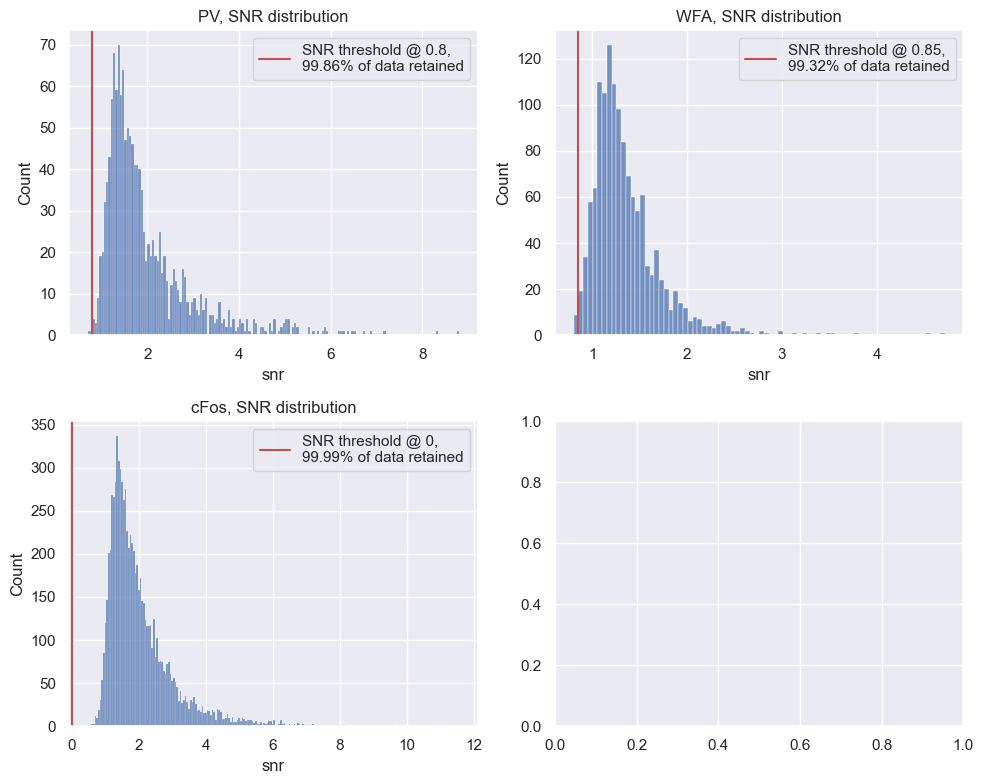

In [4]:
# let's see how much of the data was thresholded out
df_snr = get_snr(df)

sns.set_theme()
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
axs = axs.ravel()

df_PV = df_snr.query('stain == "PV"')
df_WFA = df_snr.query('stain == "WFA"')
df_cFos = df_snr.query('stain == "cFos"')

g0 = sns.histplot(x='snr', data=df_snr.query('stain == "PV"'), ax=axs[0], binwidth=0.05)
g0.set_title('PV, SNR distribution')
g0.axvline(0.8, c='r', label=f'SNR threshold @ 0.8,\n{np.round(len(df_PV.query("snr > 0.8"))/len(df_PV)*100,2)}% of data retained')
g0.legend()

g1 = sns.histplot(x='snr', data=df_snr.query('stain == "WFA"'), ax=axs[1], binwidth=0.05)
g1.set_title('WFA, SNR distribution')
g1.axvline(0.85, c='r', label=f'SNR threshold @ 0.85,\n{np.round(len(df_WFA.query("snr > 0.85"))/len(df_WFA)*100,2)}% of data retained')
g1.legend()

g2 = sns.histplot(x='snr', data=df_snr.query('stain == "cFos"'), ax=axs[2], binwidth=0.05)
g2.set_title('cFos, SNR distribution')
g2.axvline(0, c='r', label=f'SNR threshold @ 0,\n{np.round(len(df_cFos.query("snr > 0"))/len(df_cFos)*100,2)}% of data retained')
g2.legend()
plt.tight_layout()
plt.show()

# Computing mean - background, adjusting raw intensities
for some reason, the way polygon subtracts the background col from the mean_intensity col isn't quite right, so here I'm subtracting background from mean_intensity myself and tossing it in a new col called "mmbg".
As with the previous set from AG, we again observe negative raw mean - background intensities. For consitency, I will add the minimum observed intensity for each stain type to all other cells for that stain type.

In [5]:
df = df_snr_filt

# compute mean - background "by hand" (the polygon values are slightly off)
df['mmbg'] = df.mean_intensity.astype('f') - df.background.astype('f')

print('min raw intensity:')
for stain in df.stain.unique():
    df_stain = df.query(f'stain == "{stain}"')
    m = np.min(df_stain.mmbg)
    print(f'{stain}: {m}')

print('\nnegative mean-background counts, percent:')
for stain in df.stain.unique():
    df_stain = df.query(f'stain == "{stain}"')
    n = df_stain.query(f'mmbg < 0').__len__()
    print(f'{stain}: {n}; {np.round(n/df_stain.__len__()*100,2)}% of {stain} cells')

# "raising the floor" intensity for each stain
adjusted = []
for stain in df.stain.unique():
    df_stain = df.query(f'stain == "{stain}"').copy()
    stain_min = np.min(df_stain.mmbg)
    df_stain['adj_mmbg'] = df_stain.mmbg + abs(stain_min)
    adjusted.append(df_stain)

df_adj = pd.concat(adjusted)
display(df_adj.head())

min raw intensity:
PV: -12.426300048828125
WFA: -11.691001892089844
cFos: -15.613300323486328

negative mean-background counts, percent:
PV: 35; 2.52% of PV cells
WFA: 105; 7.99% of WFA cells
cFos: 283; 3.53% of cFos cells


,iid_rid,dummy_PV,dummy_WFA,dummy_cFos,image_name,roi_id,stain,CoM_x,CoM_y,background,...,grouping,agg_grouping,updated_grouping,true_grouping,react,treat,treatment,snr,mmbg,adj_mmbg
0,KET10_1_r1c1_left_0-000-00000_PV,True,False,False,KET10_1_r1c1_left,0-000-00000_PV,PV,502.88,236.10,88.7182,...,"('0-000-00000_PV',)","('0-000-00000_PV',)",NaN,"('0-000-00000_PV',)",FR1,SAL,FR1_SAL,1.438262,38.881798,51.308098
1,KET10_1_r1c1_left_0-000-00001_PV,True,False,False,KET10_1_r1c1_left,0-000-00001_PV,PV,491.89,306.14,88.7182,...,"('0-000-00001_PV',)","('0-000-00001_PV',)",NaN,"('0-000-00001_PV',)",FR1,SAL,FR1_SAL,1.288913,25.631798,38.058098
2,KET10_1_r1c1_left_0-000-00002_PV,True,False,False,KET10_1_r1c1_left,0-000-00002_PV,PV,436.16,167.66,88.7182,...,"('0-000-00002_PV',)","('0-000-00002_PV',)",NaN,"('0-000-00002_PV',)",FR1,SAL,FR1_SAL,1.456156,40.469299,52.895599
3,KET10_1_r1c1_left_0-000-00003_PV,True,False,False,KET10_1_r1c1_left,0-000-00003_PV,PV,412.90,400.94,88.7182,...,"('0-000-00003_PV',)","('0-000-00003_PV',)",NaN,"('0-000-00003_PV',)",FR1,SAL,FR1_SAL,1.600574,53.281799,65.708099
4,KET10_1_r1c1_left_0-000-00005_PV,True,False,False,KET10_1_r1c1_left,0-000-00005_PV,PV,342.01,390.99,88.7182,...,"('0-000-00005_PV',)","('0-000-00005_PV',)",NaN,"('0-000-00005_PV',)",FR1,SAL,FR1_SAL,1.272569,24.181801,36.608101


### as an aside, how far off is Polygon's mean-background subtraction?
on average it's off by 0.538 (the mean absolute error) with an RMSE of 1.789, but ranges as far as -12 to +36 which is a bit concerning given that this operation should just be simple arithmetic. Going forward I'm just going to be doing the subtraction myself.

RMSE: 1.78968662217477


count    10731.000000
mean         0.538408
std          1.706859
min        -12.094403
25%         -0.185752
50%          0.395102
75%          1.188951
max         36.594597
dtype: float64

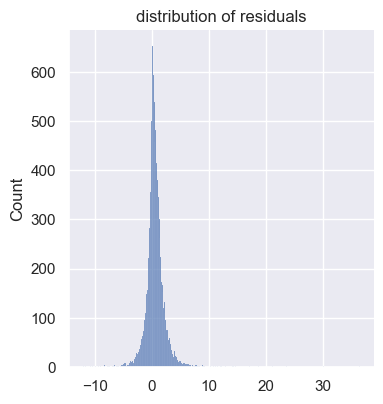

In [6]:
# let's visualize the error in polygon's bg subtracted vs the one I did here
diff = df_adj['mean-background'].astype(float) - df_adj.mmbg
diff_rmse = np.sqrt(np.sum(diff ** 2)/diff.__len__())
print(f'RMSE: {diff_rmse}')

sns.set_theme()
sns.displot(data=diff, height=4)
plt.title('distribution of residuals')

# in this describe call, mean represents MAE (the mean absolute error)
# descriptive statistics of residuals (polygon's mean-background vs simply subtracting "by hand")
diff.describe()

# both MAE and RMSE are metrics to describe error but weight large errors differently.
# i.e. if being off by 10 is twice as bad as being off by 5, then MAE is appropriate
# but if being off by 10 is much worse than being off by 5, then RMSE is appropriate.

# Compute normalized mean-background

In [7]:
df = df_adj

def normalize_intensity(df, norm_condition, col='mean-background'):
    '''
    computes the mean of rows of the norm_condition and divides mean-background by this mean,
    normalizing all data to the mean of the norm_condition. sets normalized value into new
    column called "norm mean-background" and returns new dataframe containing normalized intensity.
    '''
    df_norm = df[df.treatment == norm_condition]
    norm_mean = df_norm[col].astype('f').mean()

    df_norm = df.copy(deep=True)
    df_norm[f'norm_{col}'] = df[col].astype('f') / norm_mean

    # quickly check that the mean of the norm condition is set to about 1.00000
    # this is never exatly 1 due to small rounding errors from floating point operations
    assert round(df_norm[df_norm.treatment == norm_condition][f'norm_{col}'].mean(), 5) == 1
    
    return df_norm

def prism_reorg(df, col='norm_mean-background'):
    '''
    Takes just the norm_mean-background intensity col per rat, groups by treatment
    and 
    '''
    treatments = np.unique(df.treatment)
    reorg = []

    for t in treatments:
        df_treat = df[df.treatment == t]
        norm_int_ratn = []
        treatment_ratns = np.unique(df_treat.rat_n)

        for rat in treatment_ratns:
            norm_int = df_treat[df_treat.rat_n == rat][col]
            df_normint = pd.DataFrame({t: norm_int}).reset_index(drop=True)
            norm_int_ratn.append(df_normint)

        # concat "vertically"
        df_ratn_cols = pd.concat(norm_int_ratn, axis=0).reset_index(drop=True)

        # write csv to disk
        reorg.append(df_ratn_cols)
    
    # concat "horizontally"
    df_prism_reorg = pd.concat(reorg, axis=1)

    return df_prism_reorg

# we have to do some creative looping to access the nested coloc stain type
# getting every combination of four booleans (position matters)
# except the last one (all False) which would mean the cell had 0 stain types
### NOTE if we had 4 stains total, I would update to repeat=4
bool_combs = list(itertools.product([True, False], repeat=3))[:-1]
group = 'KET-VR5'

for bcomb in bool_combs:
    stains = np.array(['PV', 'cFos', 'WFA'])
    coloc_PV, coloc_cFos, coloc_WFA = [*bcomb]

    q = []
    if coloc_PV:
        q.append(f'dummy_PV == {coloc_PV}')
    if coloc_WFA:
        q.append(f'dummy_WFA == {coloc_WFA}')
    if coloc_cFos:
        q.append(f'dummy_cFos == {coloc_cFos}')

    query = ' and '.join(q)
    df_subset = df.query(query)
    print(len(df_subset), query)

    for stain in df_subset.stain.unique():
        target_stain = stain
        stains_filtered = stains.copy()[np.array(bcomb)]
        coloc_stain = np.delete(stains_filtered, np.argwhere(stains_filtered == target_stain))

        df_stain = df_subset.query(f'stain == "{target_stain}"')
        
        if len(coloc_stain) == 0:
            coloc_stain_type = f'single_{target_stain}'
        
        if len(coloc_stain) == 1:
            coloc_stain_type = f'{target_stain}_coloc_w_{coloc_stain[0]}'
        
        # if len(coloc_stain) == 2:
        #     coloc_stain_type = f'{target_stain}_coloc_w_{coloc_stain[0]},{coloc_stain[1]}'

        # if len(coloc_stain) == 3:
        #     coloc_stain_type = f'quad_{target_stain}'

        ### I had previously analyzed quad labeled data, but this set only goes up
        ### to triple and so we can simply call triple labeled data 'triple_{stain}'
        if len(coloc_stain) == 2:
            coloc_stain_type = f'triple_{target_stain}'


        # normalize to FR1_SAL
        df_norm = normalize_intensity(df_stain, norm_condition='FR1_SAL', col='adj_mmbg')
        df_norm['coloc_stain_type'] = coloc_stain_type
        df_norm.to_csv(f'{group}_{coloc_stain_type}_NORM.csv')

        # reorganize into cols for prism
        df_prism = prism_reorg(df_norm, col='norm_adj_mmbg')
        df_prism.to_csv(f'{group}_{coloc_stain_type}_PRISM.csv')

449 dummy_PV == True and dummy_WFA == True and dummy_cFos == True
733 dummy_PV == True and dummy_cFos == True
1101 dummy_PV == True and dummy_WFA == True
2155 dummy_PV == True
837 dummy_WFA == True and dummy_cFos == True
8662 dummy_cFos == True
2136 dummy_WFA == True


# Counting Mean Cell ns

In [8]:
# quickly making a reference df containing the total number of images taken from each rat
df_img_ns = df.groupby('rat_n')['image_name'].unique().reset_index()
df_img_ns['n_imgs'] = df_img_ns.image_name.apply(len)
df_img_ns

,rat_n,image_name,n_imgs
0,KET10_1,"[KET10_1_r1c1_left, KET10_1_r1c2_left, KET10_1...",5
1,KET10_5,"[KET10_5_r1c1_left, KET10_5_r1c1_right2, KET10...",3
2,KET11_1,"[KET11_1_r1c1_left, KET11_1_r1c1_right, KET11_...",4
3,KET11_10,"[KET11_10_r1c3_left, KET11_10_r1c3_right, KET1...",4
4,KET11_12,"[KET11_12_r1c4_right, KET11_12_r2c2_left, KET1...",4
5,KET11_13,"[KET11_13_r1c1_left, KET11_13_r1c3_left, KET11...",5
6,KET11_14,"[KET11_14_r2c3_right, KET11_14_r3c2_left, KET1...",3
7,KET11_2,"[KET11_2_r1c3_left, KET11_2_r2c1_left, KET11_2...",4
8,KET11_5,"[KET11_5_r1c1_left, KET11_5_r1c2_right, KET11_...",3
9,KET11_7,"[KET11_7_r1c1_left, KET11_7_r1c1_right, KET11_...",4


### Single stain types

In [9]:
def mean_cell_ns(df, df_img_ns, stains, tx_cols=['treat', 'react']):
    '''
    performs a series of groupby and reductions to get sum of sums per rat:
        - first groupby to count cells per image; 
        - second groupby to sum counts per rat
        - merge with df to get required labels
        - merge with df_img_ns to get n_imgs per rat

    args:
        df: pd.core.frame.DataFrame, containing data; requires cols:
            ['rat_n', 'image_name', 'stain'], cols denoted in tx_cols,
            as well as dummy_{stain} cols denoting stain type 
            colocalization
        df_img_ns: pd.core.frame.DataFrame, containing image counts
            per rat; requires cols: ['rat_n', 'image_name', 'n_imgs']
        stains: tuple; first element (str) must be target stain, all 
            remaining elements (str) denote colocalization. If no
            colocalization is intended, be sure to specify that
            stains is a tuple containing one string, e.g. ('PV',) vs
            ('PV')
        tx_cols: list strings denoting cols containing minimum 
            identifying information which denote some combination of 
            experimental treatments/conditions

    return:
        q: pd.core.frame.DataFrame containing mean cell count per image
            by rat
     '''
    # unpack stains, set base query fstring
    target_stain, *coloc_stains = stains
    q = f'stain == "{target_stain}" and dummy_{target_stain} == True'

    # build full query string, adding coloc stains if we have them
    for stain in coloc_stains:
        q = ' '.join([q, f'and dummy_{stain} == True'])

    # query data, then compute sum of sum cell counts by rat
    q = df.query(q)\
        .groupby('image_name')['rat_n'].count()\
        .reset_index().rename(columns={'rat_n':'count'})\
        .merge(df[['image_name', 'rat_n']], on='image_name', how='left')\
        .drop_duplicates()\
        .groupby('rat_n')['count'].sum().reset_index().rename(columns={'count':'sum'})\
        .merge(df[['rat_n', *tx_cols]],\
            on='rat_n', how='left')\
        .drop_duplicates().reset_index()\
        .merge(df_img_ns[['rat_n', 'n_imgs']], on='rat_n', how='left')

    # compute mean cell count per image
    q['mean_cell_n'] = q['sum'] / q['n_imgs']

    # sort by tx_cols, reorder cols
    q = q.sort_values(by=tx_cols)\
        [['rat_n', *tx_cols, 'sum', 'n_imgs', 'mean_cell_n']]\
        .reset_index().drop('index', axis=1)

    return q

mean_cell_ns(df, df_img_ns, ('PV',)).to_csv('KET-VR5_SAC_PV_mean_cell_ns.csv')
mean_cell_ns(df, df_img_ns, ('WFA',)).to_csv('KET-VR5_SAC_WFA_mean_cell_ns.csv')
mean_cell_ns(df, df_img_ns, ('cFos',)).to_csv('KET-VR5_SAC_cFos_mean_cell_ns.csv')

### Counting double stain type combinations
half of these permutations should be redundant since we enforced comlete subgraph colocalization, but all possible permutations are included here for completeness (and for spot checking: PV on WFA counts should be exactly equal to WFA on PV counts)

In [10]:
import itertools

# loop over each possible pairwise permutation (order matters) from the set of our stains
for p in itertools.permutations(('PV', 'WFA', 'cFos'), 2):
    print(p)
    mean_cell_ns(df, df_img_ns, p).to_csv(f'KET-VR5_SAC_{p[0]}_coloc_w_{p[1]}_mean_cell_ns.csv')

('PV', 'WFA')
('PV', 'cFos')
('WFA', 'PV')
('WFA', 'cFos')
('cFos', 'PV')
('cFos', 'WFA')


### Triple stain type combinations
2 of these permutations will be redundant since we enforced comlete subgraph colocalization, but all possible permutations are included here for completeness (and for spot checking: PV on WFA,cFos should be exactly equal to WFA on PV,cFos and cFos on PV,WFA)

In [11]:
mean_cell_ns(df, df_img_ns, ('PV', 'WFA', 'cFos')).to_csv('KET-VR5_SAC_triple_PV_mean_cell_ns.csv')
mean_cell_ns(df, df_img_ns, ('WFA', 'cFos', 'PV')).to_csv('KET-VR5_SAC_triple_WFA_mean_cell_ns.csv')
mean_cell_ns(df, df_img_ns, ('cFos', 'PV', 'WFA')).to_csv('KET-VR5_SAC_triple_cFos_mean_cell_ns.csv')

## Repeat cell ns, but this time with split by cFos intensity (median split)

In [12]:
def mean_cell_ns(df, df_img_ns, stains, tx_cols=['treat', 'react'], query=None):
    '''
    ### modified version of the above function to allow custom query input
    ### as well as simplified query pipeline

    performs a series of groupby and reductions to get sum of sums per rat:
        - first groupby to count cells per image; 
        - second groupby to sum counts per rat
        - merge with df to get required labels
        - merge with df_img_ns to get n_imgs per rat

    args:
        df: pd.core.frame.DataFrame, containing data; requires cols:
            ['rat_n', 'iid_rid', 'stain'], cols denoted in tx_cols,
            as well as dummy_{stain} cols denoting stain type 
            colocalization
        df_img_ns: pd.core.frame.DataFrame, containing image counts
            per rat; requires cols: ['rat_n', 'iid_rid', 'n_imgs']
        stains: tuple; first element (str) must be target stain, all 
            remaining elements (str) denote colocalization. If no
            colocalization is intended, be sure to specify that
            stains is a tuple containing one string, e.g. ('PV',) vs
            ('PV')
        tx_cols: list strings denoting cols containing minimum 
            identifying information which denote some combination of 
            experimental treatments/conditions

    return:
        q: pd.core.frame.DataFrame containing mean cell count per image
            by rat
     '''
    if not query:
        # unpack stains, set base query fstring
        target_stain, *coloc_stains = stains
        q = f'stain == "{target_stain}" and dummy_{target_stain} == True'

        # build full query string, adding coloc stains if we have them
        for stain in coloc_stains:
            q = ' '.join([q, f'and dummy_{stain} == True'])

    elif query:
        q = query

    # query data, then compute sum of sum cell counts by rat
    q = df.query(q)\
        .groupby('rat_n')['iid_rid'].count().reset_index()\
        .rename(columns={'iid_rid':'sum'})\
        .merge(df[['rat_n', *tx_cols]], on='rat_n', how='left')\
        .drop_duplicates().reset_index()\
        .merge(df_img_ns[['rat_n', 'n_imgs']], on='rat_n', how='left')

    # compute mean cell count per image
    q['mean_cell_n'] = q['sum'] / q['n_imgs']

    # sort by tx_cols, reorder cols
    q = q.sort_values(by=tx_cols)\
        [['rat_n', *tx_cols, 'sum', 'n_imgs', 'mean_cell_n']]\
        .reset_index().drop('index', axis=1)

    return q

df_cFos = df.query('dummy_cFos == True and stain =="cFos"').copy()
cFos_median = df_cFos['adj_mmbg'].median()
df_cFos['cFos_split'] = df_cFos['adj_mmbg'].apply(lambda x: 'cFos_hi' if x > cFos_median else 'cFos_lo')

print(df_cFos.columns)
print(df_cFos.shape)
df_cFos.head()

Index(['iid_rid', 'dummy_PV', 'dummy_WFA', 'dummy_cFos', 'image_name',
       'roi_id', 'stain', 'CoM_x', 'CoM_y', 'background', 'mean_intensity',
       'mean-background', 'filename', 'rat_n', 'grouping', 'agg_grouping',
       'updated_grouping', 'true_grouping', 'react', 'treat', 'treatment',
       'snr', 'mmbg', 'adj_mmbg', 'cFos_split'],
      dtype='object')
(8028, 25)


,iid_rid,dummy_PV,dummy_WFA,dummy_cFos,image_name,roi_id,stain,CoM_x,CoM_y,background,...,agg_grouping,updated_grouping,true_grouping,react,treat,treatment,snr,mmbg,adj_mmbg,cFos_split
27,KET10_1_r1c1_left_0-005-00000_cFos,False,False,True,KET10_1_r1c1_left,0-005-00000_cFos,cFos,264.31,466.13,27.9607,...,"('0-005-00000_cFos',)",NaN,"('0-005-00000_cFos',)",FR1,SAL,FR1_SAL,1.572207,15.999300,31.612600,cFos_lo
28,KET10_1_r1c1_left_0-005-00001_cFos,False,False,True,KET10_1_r1c1_left,0-005-00001_cFos,cFos,163.15,275.02,27.9607,...,"('0-005-00001_cFos',)",NaN,"('0-005-00001_cFos',)",FR1,SAL,FR1_SAL,1.409364,11.446100,27.059401,cFos_lo
29,KET10_1_r1c1_left_0-005-00002_cFos,False,False,True,KET10_1_r1c1_left,0-005-00002_cFos,cFos,141.76,42.20,27.9607,...,"('0-005-00002_cFos',)",NaN,"('0-005-00002_cFos',)",FR1,SAL,FR1_SAL,3.196716,61.421700,77.035004,cFos_hi
30,KET10_1_r1c1_left_0-005-00003_cFos,False,False,True,KET10_1_r1c1_left,0-005-00003_cFos,cFos,124.77,390.76,27.9607,...,"('0-005-00003_cFos',)",NaN,"('0-005-00003_cFos',)",FR1,SAL,FR1_SAL,1.844890,23.623701,39.237000,cFos_hi
31,KET10_1_r1c1_left_0-005-00004_cFos,False,False,True,KET10_1_r1c1_left,0-005-00004_cFos,cFos,35.89,12.95,27.9607,...,"('0-005-00004_cFos',)",NaN,"('0-005-00004_cFos',)",FR1,SAL,FR1_SAL,1.253313,7.082800,22.696100,cFos_lo


### cFos_hi

In [13]:
# single cFos_hi
mean_cell_ns(df_cFos.query('cFos_split == "cFos_hi"'), df_img_ns, ('cFos',), tx_cols=['treat','react','cFos_split'])\
    .to_csv('KET-VR5_SAC_cFos_hi_mean_cell_ns.csv')

### not sure if we need the following but i'll just do it in case since i'm here 
# cFos_hi on PV
mean_cell_ns(df_cFos.query('cFos_split == "cFos_hi"'), df_img_ns, ('cFos','PV'), tx_cols=['treat','react','cFos_split'])\
    .to_csv('KET-VR5_SAC_cFos_hi_coloc_w_PV_mean_cell_ns.csv')

# cFos hi on WFA
mean_cell_ns(df_cFos.query('cFos_split == "cFos_hi"'), df_img_ns, ('cFos','WFA'), tx_cols=['treat','react','cFos_split'])\
    .to_csv('KET-VR5_SAC_cFos_hi_coloc_w_WFA_mean_cell_ns.csv')

# triple cFos_hi
mean_cell_ns(df_cFos.query('cFos_split == "cFos_hi"'), df_img_ns, ('cFos','PV','WFA'), tx_cols=['treat','react','cFos_split'])\
    .to_csv('KET-VR5_SAC_triple_cFos_hi_coloc_mean_cell_ns.csv')

### cFos_lo

In [14]:
# single cFos_lo
mean_cell_ns(df_cFos.query('cFos_split == "cFos_lo"'), df_img_ns, ('cFos',), tx_cols=['treat','react','cFos_split'])\
    .to_csv('KET-VR5_SAC_cFos_lo_mean_cell_ns.csv')

### not sure if we need the following but i'll just do it in case since i'm here 
# cFos_lo on PV
mean_cell_ns(df_cFos.query('cFos_split == "cFos_lo"'), df_img_ns, ('cFos','PV'), tx_cols=['treat','react','cFos_split'])\
    .to_csv('KET-VR5_SAC_cFos_lo_coloc_w_PV_mean_cell_ns.csv')

# cFos_lo on WFA
mean_cell_ns(df_cFos.query('cFos_split == "cFos_lo"'), df_img_ns, ('cFos','WFA'), tx_cols=['treat','react','cFos_split'])\
    .to_csv('KET-VR5_SAC_cFos_lo_coloc_w_WFA_mean_cell_ns.csv')

# triple cFos_lo
mean_cell_ns(df_cFos.query('cFos_split == "cFos_lo"'), df_img_ns, ('cFos','PV','WFA'), tx_cols=['treat','react','cFos_split'])\
    .to_csv('KET-VR5_SAC_triple_cFos_lo_coloc_mean_cell_ns.csv')